# Fitting a spectrum model  using Gradient Descent based optimizations in JAXopt

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp

Here, we use the mock spectrum generated by the tutorial of "Foward modeling". 

In [3]:
dat=pd.read_csv("spectrum.txt",delimiter=",",names=("wav","flux"))

We add Gaussian noise to data. nusd is the observing wavenumber grid. 

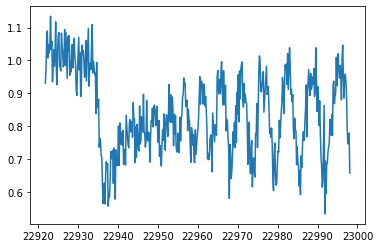

In [4]:
wavd=dat["wav"].values[12:-12]
flux=dat["flux"].values[12:-12]
nusd=jnp.array(1.e8/wavd[::-1])
sigmain=0.05
norm=40000
nflux=flux/norm+np.random.normal(0,sigmain,len(wavd))
plt.plot(wavd[::-1],nflux)



In [5]:
from exojax.spec.lpf import xsmatrix
from exojax.spec.exomol import gamma_exomol
from exojax.spec.hitran import SijT, doppler_sigma, gamma_natural
from exojax.spec.rtransfer import rtrun, dtauM, dtauCIA, wavenumber_grid
from exojax.spec import planck, response
from exojax.spec import molinfo
from exojax.utils.constants import RJ, pc, Rs, c

The model is almost same as the forward modeling, but we will infer here Rp, RV, MMR_CO, T0, alpha, and Vsini. 

In [6]:
from exojax.spec import rtransfer as rt

NP = 100
Parr, dParr, k = rt.pressure_layer(NP=NP)
Nx = 1500
nus, wav, res = wavenumber_grid(np.min(wavd) - 5.0,
                                np.max(wavd) + 5.0,
                                Nx,
                                unit="AA")

R = 100000.
beta = c / (2.0 * np.sqrt(2.0 * np.log(2.0)) * R)

molmassCO = molinfo.molmass("CO")
mmw = 2.33  #mean molecular weight
mmrH2 = 0.74
molmassH2 = molinfo.molmass("H2")
vmrH2 = (mmrH2 * mmw / molmassH2)  #VMR

Mp = 33.2  #fixing mass...


xsmode assumes ESLOG in wavenumber space: mode=lpf


/home/kawahara/exojax/src/exojax/utils/grids.py:124: UserWarning: Resolution may be too small. R=399489.9978380062
  warnings.warn('Resolution may be too small. R=' + str(resolution),


Loading the molecular database of CO and the CIA

In [7]:
from exojax.spec import moldb, contdb
mdbCO=moldb.MdbExomol('.database/CO/12C-16O/Li2015',nus,crit=1.e-46)
cdbH2H2=contdb.CdbCIA('.database/H2-H2_2011.cia',nus)

Background atmosphere:  H2
Reading .database/CO/12C-16O/Li2015/12C-16O__Li2015.trans.bz2
.broad is used.
Broadening code level= a0
H2-H2


We have only 39 CO lines. 

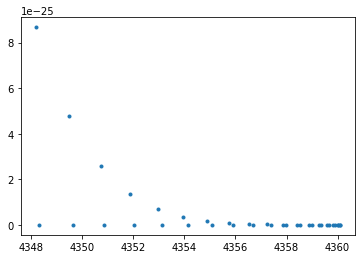

In [8]:
plt.plot(mdbCO.nu_lines,mdbCO.Sij0,".")

Again, numatrix should be precomputed prior to HMC-NUTS.

In [9]:
from exojax.spec import make_numatrix0
numatrix_CO=make_numatrix0(nus,mdbCO.nu_lines)

In [10]:
#Or you can use initspec.init_lpf instead.
from exojax.spec import initspec
numatrix_CO=initspec.init_lpf(mdbCO.nu_lines,nus)

In [11]:
#reference pressure for a T-P model                                             
Pref=1.0 #bar
ONEARR=np.ones_like(Parr)
ONEWAV=jnp.ones_like(nflux)

In [12]:
import jax.numpy as jnp
from jax import vmap, jit

Now we write the model, which is used in HMC-NUTS.

In [13]:

#response and rotation settings 
from exojax.spec.response import ipgauss_sampling
from exojax.spec.spin_rotation import convolve_rigid_rotation
from exojax.utils.grids import velocity_grid
vsini_max = 100.0
vr_array = velocity_grid(res, vsini_max)


def model_c(params,boost,nu1):
    Rp,RV,MMR_CO,T0,alpha,vsini,RV=params*boost
    g=2478.57730044555*Mp/Rp**2 #gravity                                        
    u1=0.0
    u2=0.0
    #T-P model//                                                                
    Tarr = T0*(Parr/Pref)**alpha

    #line computation CO                                                        
    qt_CO=vmap(mdbCO.qr_interp)(Tarr)

    def obyo(nusd,nus,numatrix_CO,mdbCO,cdbH2H2):
        #CO                                                                     
        SijM_CO=jit(vmap(SijT,(0,None,None,None,0)))\
            (Tarr,mdbCO.logsij0,mdbCO.dev_nu_lines,mdbCO.elower,qt_CO)
        gammaLMP_CO = jit(vmap(gamma_exomol,(0,0,None,None)))\
            (Parr,Tarr,mdbCO.n_Texp,mdbCO.alpha_ref)
        gammaLMN_CO=gamma_natural(mdbCO.A)
        gammaLM_CO=gammaLMP_CO+gammaLMN_CO[None,:]
        
        sigmaDM_CO=jit(vmap(doppler_sigma,(None,0,None)))\
            (mdbCO.dev_nu_lines,Tarr,molmassCO)
        xsm_CO=xsmatrix(numatrix_CO,sigmaDM_CO,gammaLM_CO,SijM_CO)
        dtaumCO=dtauM(dParr,xsm_CO,MMR_CO*ONEARR,molmassCO,g)
        #CIA                                                                    
        dtaucH2H2=dtauCIA(nus,Tarr,Parr,dParr,vmrH2,vmrH2,\
                          mmw,g,cdbH2H2.nucia,cdbH2H2.tcia,cdbH2H2.logac)
        dtau=dtaumCO+dtaucH2H2
        sourcef = planck.piBarr(Tarr,nus)
        F0=rtrun(dtau,sourcef)/norm
        
        Frot = convolve_rigid_rotation(F0, vr_array, vsini, u1, u2)
        mu = ipgauss_sampling(nusd, nus, Frot, beta, RV)
        return mu
    
    model=obyo(nu1,nus,numatrix_CO,mdbCO,cdbH2H2)
    return model

Here, we use JAXopt as an optimizer. JAXopt is not automatically installed. If you need install it by pip:

pip install jaxopt

In [14]:
import jaxopt

We use a GradientDescent as an optimizer. Let's normalize the parameters. 

In [15]:
#Rp,RV,MMR_CO,T0,alpha,vsini, RV
boost=np.array([1.0,10.0,0.1,1000.0,1.e-3,10.0,10.0])
initpar=np.array([0.8,9.0,0.1,1200.0,0.1,17.0,0.0])/boost

Define the objective function by a L2 norm.

In [16]:
def objective(params):
    f=nflux-model_c(params,boost,nusd)
    g=jnp.dot(f,f)
    return g

Then, run the gradient descent. 

In [16]:
gd = jaxopt.GradientDescent(fun=objective, maxiter=1000, stepsize=1.e-4)
res = gd.run(init_params=initpar)
params, state = res

The best-fit parameters

In [17]:
params*boost

DeviceArray([9.9508977e-01, 9.0000000e+00, 5.0294059e-03, 1.3074337e+03,
             9.9846527e-02, 1.9954092e+01, 9.6740799e+00], dtype=float32)

Plot the results. It works well!

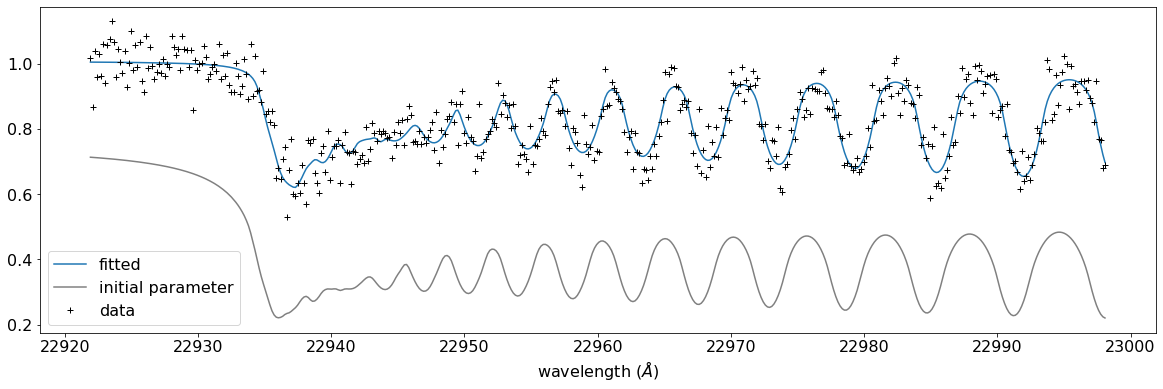

In [18]:
model=model_c(params,boost,nusd)
inmodel=model_c(initpar,boost,nusd)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,6.0))
ax.plot(wavd[::-1],model,color="C0",label="fitted")
ax.plot(wavd[::-1],inmodel,color="gray",label="initial parameter")
ax.plot(wavd[::-1],nflux,"+",color="black",label="data")
plt.xlabel("wavelength ($\AA$)",fontsize=16)
plt.legend(fontsize=16)
plt.tick_params(labelsize=16)
plt.savefig("gradient_descent_jaxopt.png")

One by one update

In [26]:
import tqdm
gd = jaxopt.GradientDescent(fun=objective, stepsize=1.e-4)
state = gd.init_state(initpar)
params=np.copy(initpar)

params_gd=[]
Nit=300
for _ in  tqdm.tqdm(range(Nit)):
    params,state=gd.update(params,state)
    params_gd.append(params)

100%|██████████| 30/30 [00:21<00:00,  1.41it/s]


## Using ADAM optimizer

In [21]:
from jaxopt import OptaxSolver
import optax


In [23]:
import tqdm
adam = OptaxSolver(opt=optax.adam(2.e-2), fun=objective)
state = adam.init_state(initpar)
params=np.copy(initpar)

params_adam=[]
Nit=300
for _ in  tqdm.tqdm(range(Nit)):
    params,state=adam.update(params,state)
    params_adam.append(params)

100%|██████████| 30/30 [00:13<00:00,  2.29it/s]


In [120]:
# if you wanna optimize at once, run the following: 
# res = solver.run(init_params=initpar)
# params, state = res

In [24]:
params*boost

DeviceArray([6.8444943e-01, 9.0000000e+00, 7.4127272e-02, 1.3369791e+03,
             9.9759318e-02, 2.2218807e+01, 5.4696321e+00], dtype=float32)

## make a movie

make the movie directory (mkdir movie)

In [28]:
inmodel=model_c(initpar,boost,nusd)
for i in tqdm.tqdm(range(Nit)):
    spec_gd=model_c(params_gd[i],boost,nusd)
    spec_adam=model_c(params_adam[i],boost,nusd)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,6.0))
    ax.plot(wavd[::-1],spec_gd,color="C0",label="GD")
    ax.plot(wavd[::-1],spec_adam,color="C1",label="ADAM")
    ax.plot(wavd[::-1],inmodel,color="gray",label="initial parameter")
    ax.plot(wavd[::-1],nflux,"+",color="black",label="data")
    plt.xlabel("wavelength ($\AA$)",fontsize=16)
    plt.tick_params(labelsize=16)
    plt.ylim(0.0,1.2)
    plt.legend(loc="lower left")
    plt.savefig("movie/gradient_descent_jaxopt"+str(i).zfill(4)+".png")
    plt.close()

100%|██████████| 30/30 [00:14<00:00,  2.00it/s]


In [ ]:
#for instance, make a movie by
# > ffmpeg -r 30 -i gradient_descent_jaxopt%04d.png -vcodec libx264 -pix_fmt yuv420p -r 60 outx.mp4